<h1>LOAD ALL NECESSARY LIBRARIES</h1>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# nltk.download('vader_lexicon')
import nltk.corpus
import os
import sys
import json
from collections import Counter
import swifter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
from ipywidgets import FloatProgress
from tqdm import tqdm

<h1>Load the json File</h1>

In [6]:
filename="AMAZON_FASHION"

In [7]:
filepath = ('Datasets/'+filename+'.json')
df_raw = pd.read_json(filepath,lines=True)

In [8]:
df_raw.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,vote,image
0,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
1,2,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
2,3,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN
3,5,True,"07 19, 2014",A29HLOUW0NS0EH,7106116521,Patricia R. Erwin,Exactly what I wanted.,Five Stars,1405728000,NaN,NaN,NaN
4,4,True,"05 31, 2014",A7QS961ROI6E0,7106116521,REBECCA S LAYTON,These little plastic backs work great. No mor...,Works great!,1401494400,NaN,NaN,NaN


<h1>Generate sentiment</h1>

In [9]:
# nltk.download('vader_lexicon')
sentiment = SentimentIntensityAnalyzer()
sid_obj = SentimentIntensityAnalyzer()
def get_compound_score(text):
    return sid_obj.polarity_scores(str(text))['compound']


df_raw['sentiment']=df_raw['reviewText'].swifter.apply(get_compound_score)

count=0
avg_rating=0
comp_rating=0
for index, row in df_raw.iterrows():
    ss = sentiment.polarity_scores(str(row['reviewText']))
    for k in sorted(ss):
        compound_score =ss['compound']
    
    avg_rating+=(compound_score+1)/2.0*5.0
    comp_rating+=(row.overall+compound_score/5.0)*(5/6)
    count+=1
    
# Calculate final average rating if count is greater than 0 to avoid division by zero
if count > 0:
    avg_rating /= count
    comp_rating /= count


Pandas Apply:   0%|          | 0/883634 [00:00<?, ?it/s]

<h1>Save and Load the Sentiment file</h1>

In [10]:
#Backup all the modifications in csv file
df_raw.to_csv('output/'+filename+'.csv', index=False)
df_raw=pd.read_csv('output/'+filename+'.csv')

In [11]:
df_raw['reviewTime'] = pd.to_datetime(df_raw['unixReviewTime'], unit='s')
df_raw.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,vote,image,sentiment
0,4,False,2014-08-25,A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,0.8074
1,2,True,2014-08-24,A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,0.0000
2,3,False,2014-07-27,A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN,0.2263
3,5,True,2014-07-19,A29HLOUW0NS0EH,7106116521,Patricia R. Erwin,Exactly what I wanted.,Five Stars,1405728000,NaN,NaN,NaN,0.0000
4,4,True,2014-05-31,A7QS961ROI6E0,7106116521,REBECCA S LAYTON,These little plastic backs work great. No mor...,Works great!,1401494400,NaN,NaN,NaN,0.7883


<h1>Now group by reviewTime for 1 Week</h1>
<p>reviewCount-> count all reviews in a week</p>
<p>sentiment-> mean of all sentiments for diff products in a week</p>
<p>overall->mean of all ratings in a week</p>
<p>helpfulness->count of the number of people who liked the review</p>

In [12]:

df_grouped = df_raw.groupby(pd.Grouper(key='reviewTime', freq='7D')).agg(
    review_count=('reviewerID', 'count'),
    average_sentiment=('sentiment', 'mean'),
    average_rating=('overall', 'mean'),
    helpfulness=('vote','count')
).reset_index()

In [13]:
df_grouped=df_grouped.fillna(0)
df_grouped.set_index('reviewTime', inplace=True)
df_grouped.head()

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2002-11-11,2,0.9624,3.5,2
2002-11-18,0,0.0000,0.0,0
2002-11-25,1,0.9241,5.0,1
2002-12-02,0,0.0000,0.0,0
2002-12-09,1,0.9012,4.0,0


In [14]:
df_grouped.tail(20)

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2018-05-21,1531,0.507176,4.062704,24
2018-05-28,1408,0.477757,4.006392,14
2018-06-04,1386,0.488973,4.013709,13
2018-06-11,1471,0.517414,4.153637,14
2018-06-18,1358,0.511686,4.045655,16
2018-06-25,1435,0.496924,4.025087,14
2018-07-02,1279,0.497836,4.093823,8
2018-07-09,1062,0.496965,4.030132,7
2018-07-16,850,0.480677,3.943529,6


In [15]:
# See average sentiment
print(df_grouped['average_sentiment'].min(),df_grouped['average_sentiment'].max())

-0.8781 0.9826


In [16]:
min_sentiment=df_grouped['average_sentiment'].min()
max_sentiment=df_grouped['average_sentiment'].max()

In [17]:
df_grouped['average_sentiment']=1+(df_grouped['average_sentiment']-min_sentiment)*(5-1)/(max_sentiment-min_sentiment)

In [18]:
df_grouped.tail(2)

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2018-09-24,143,4.028804,4.076923,0
2018-10-01,7,3.123717,2.714286,0


In [19]:

max_value = df_grouped['helpfulness'].max()
min_value = df_grouped['helpfulness'].min()

df_grouped['helpfulness']=1+ (df_grouped['helpfulness']-min_value)*(4)/(max_value-min_value)

In [20]:
print(df_grouped['helpfulness'].min(),df_grouped['helpfulness'].max())

1.0 5.0


In [21]:
df_grouped.tail(6)

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2018-08-27,560,3.930557,4.017857,1.035088
2018-09-03,375,3.873555,3.984000,1.026316
2018-09-10,382,3.925478,4.109948,1.013158
2018-09-17,249,3.946093,4.108434,1.008772
2018-09-24,143,4.028804,4.076923,1.000000
2018-10-01,7,3.123717,2.714286,1.000000


In [22]:
df_grouped['mixture']=df_grouped['helpfulness']*df_grouped['average_sentiment']*df_grouped['average_rating']

In [23]:

max_value = df_grouped['mixture'].max()
min_value = df_grouped['mixture'].min()

print(min_value,max_value)

0.0 76.21824575920093


In [24]:
df_grouped['mixture']=1+ (df_grouped['mixture']-min_value)*(4)/(max_value-min_value)

In [25]:
df_grouped.tail()

,review_count,average_sentiment,average_rating,helpfulness,mixture
reviewTime,,,,,
2018-09-03,375,3.873555,3.984000,1.026316,1.831211
2018-09-10,382,3.925478,4.109948,1.013158,1.857841
2018-09-17,249,3.946093,4.108434,1.008772,1.858297
2018-09-24,143,4.028804,4.076923,1.000000,1.862005
2018-10-01,7,3.123717,2.714286,1.000000,1.444967


In [26]:
print(df_grouped['mixture'].max(),df_grouped['mixture'].min())


5.0 1.0


In [27]:
max_value = df_grouped['review_count'].max()
min_value = df_grouped['review_count'].min()

print(min_value,max_value)
df_grouped['review_count']=1+ (df_grouped['review_count']-min_value)*(4)/(max_value-min_value)

0 9323


<h1>Now training the models</h1>

In [28]:
#  split train/valid/test
n = len(df_grouped)
train_end = int(n * 0.7)
val_end = n - int(n * 0.1)
test_end = n

In [29]:
print("Total dataset length=",n);
print("Datasets to be trained upon:",train_end);
print("Datasets to be validated upon:",val_end-train_end);
print("Datasets to be tested upon:",test_end-val_end);

Total dataset length= 830
Datasets to be trained upon: 581
Datasets to be validated upon: 166
Datasets to be tested upon: 83


In [30]:
seq_len=16
pred_len=60
batch_size=60

df_grouped_bak=df_grouped

df_grouped_bak['review_count'] = np.log(df_grouped_bak['review_count']+1)

log_min = df_grouped_bak['review_count'].min()
log_max = df_grouped_bak['review_count'].max()


df_grouped_bak=df_grouped_bak/10


In [31]:
df_grouped_bak['review_count']

reviewTime
2002-11-11    0.069358
2002-11-18    0.069315
2002-11-25    0.069336
2002-12-02    0.069315
2002-12-09    0.069336
                ...   
2018-09-03    0.077052
2018-09-10    0.077191
2018-09-17    0.074519
2018-09-24    0.072336
2018-10-01    0.069465
Name: review_count, Length: 830, dtype: float64

In [32]:
# df_grouped_bak['review_count']

In [33]:
sum(df_grouped_bak.mixture<0)

0

In [34]:
train_df = df_grouped_bak[:train_end]
val_df = df_grouped_bak[train_end - seq_len: val_end]
test_df = df_grouped_bak[val_end - seq_len: test_end]

In [35]:
def _split_window(data,target_slice=slice(0,None)):
    inputs = data[:, : seq_len, :]
    labels = data[:, seq_len :, target_slice]
    inputs.set_shape([None, seq_len, None])
    labels.set_shape([None, pred_len, None])
    return inputs, labels

def _make_dataset(data, shuffle=True, targets=None):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=(seq_len + pred_len),
        sequence_stride=5,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    ds = ds.map(_split_window)
    return ds

def get_train(self, shuffle=True):
    return self._make_dataset(self.train_df, shuffle=shuffle)


In [36]:
import tensorflow as tf
train_data  =   _make_dataset(train_df, shuffle=False)
val_data    =   _make_dataset(val_df, shuffle=False)
test_data   =   _make_dataset(test_df, shuffle=False)

In [37]:
from tensorflow.keras import layers

def res_block(inputs, ff_dim):

  norm = layers.LayerNormalization

  # Time mixing
  x = norm(axis=[-2, -1])(inputs)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(x.shape[-1], activation='relu')(x)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.6)(x)
  res = x + inputs

  # Feature mixing
  x = norm(axis=[-2, -1])(res)
  x = layers.Dense(ff_dim, activation='relu')(x)  # [Batch, Input Length, FF_Dim]
  x = layers.Dropout(0.6)(x)
  x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.6)(x)
  return (x + res ) #* (avg_rating/5.0) * (comp_rating/5.0)

In [38]:
def build_model(
    input_shape,
    pred_len,
    n_block,
    ff_dim,
    target_slice,
):

  inputs = tf.keras.Input(shape=input_shape)
  x = inputs  # [Batch, Input Length, Channel]
  for _ in range(n_block):
    x = res_block(x, ff_dim)

  if target_slice:
    x = x[:, :, target_slice]

  # Temporal projection
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
  outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

  return tf.keras.Model(inputs, outputs)

In [39]:
n_feature = train_df.shape[-1]
model = build_model(
    input_shape=(seq_len, n_feature),
    pred_len=pred_len,
    n_block=16,
    ff_dim=64,
    target_slice=slice(0,None)
)

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint
# tf.keras.utils.set_random_seed(7)
tf.keras.utils.set_random_seed(7)

initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=24,
    decay_rate=0.97,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer, loss='mse', metrics=['mse'])
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',           
    monitor='val_mse',        
    save_best_only=True,       # Save only the best model (lowest val_loss)
    mode='min',                
    verbose=1,
)

In [41]:
history = model.fit(
    train_data,
    epochs= 1000,
    validation_data=test_data,
    callbacks=[checkpoint_callback]
)

Epoch 1/1000
1/2 [==============>...............] - ETA: 9s - loss: 30.4680 - mse: 30.4680
Epoch 1: val_mse improved from inf to 1.89645, saving model to best_model.h5
2/2 [==============================] - 12s 2s/step - loss: 131.5167 - mse: 131.5167 - val_loss: 1.8965 - val_mse: 1.8965
Epoch 2/1000
2/2 [==============================] - ETA: 0s - loss: 30.8111 - mse: 30.8111
Epoch 2: val_mse did not improve from 1.89645
2/2 [==============================] - 0s 136ms/step - loss: 30.8111 - mse: 30.8111 - val_loss: 29.5338 - val_mse: 29.5338
Epoch 3/1000
1/2 [==============>...............] - ETA: 0s - loss: 63.6084 - mse: 63.6084
Epoch 3: val_mse did not improve from 1.89645
2/2 [==============================] - 0s 113ms/step - loss: 44.5079 - mse: 44.5079 - val_loss: 49.3523 - val_mse: 49.3523
Epoch 4/1000
1/2 [==============>...............] - ETA: 0s - loss: 29.9678 - mse: 29.9678
Epoch 4: val_mse did not improve from 1.89645
2/2 [==============================] - 0s 110ms/step -

In [42]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')
predictions = model.predict(test_data)

scaled_preds = predictions[-1,:,:]

scaled_preds.shape

cols = ['review_count','average_sentiment','average_rating','helpfulness','mixture']
scaled_preds_df = pd.DataFrame(scaled_preds)
scaled_preds_df.columns = cols


1/1 [==============================] - 2s 2s/step


In [43]:
df_grouped

,review_count,average_sentiment,average_rating,helpfulness,mixture
reviewTime,,,,,
2002-11-11,0.693576,4.956575,3.500000,1.008772,1.918425
2002-11-18,0.693147,2.887677,0.000000,1.000000,1.000000
2002-11-25,0.693362,4.874241,5.000000,1.004386,2.284632
2002-12-02,0.693147,2.887677,0.000000,1.000000,1.000000
2002-12-09,0.693362,4.825012,4.000000,1.000000,2.012883
...,...,...,...,...,...
2018-09-03,0.770521,3.873555,3.984000,1.026316,1.831211
2018-09-10,0.771910,3.925478,4.109948,1.013158,1.857841
2018-09-17,0.745186,3.946093,4.108434,1.008772,1.858297


average_sentiment
average_rating
helpfulness
mixture


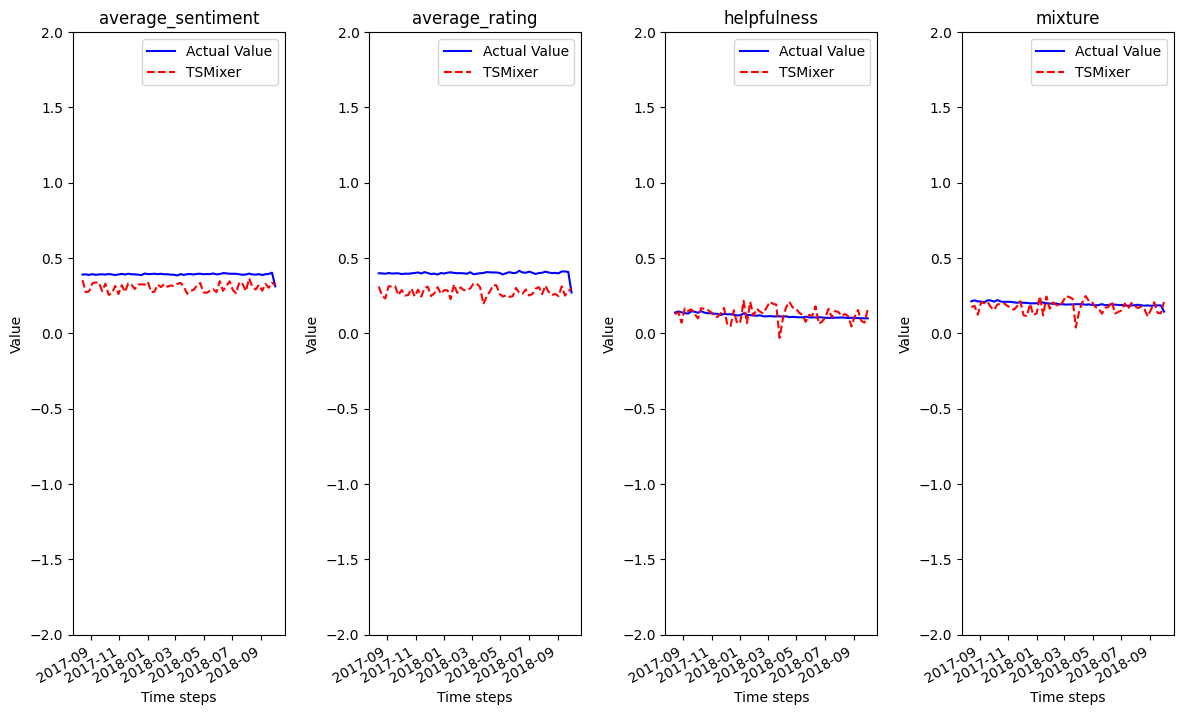

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,8))

for i, ax in enumerate(axes.flatten()[0:4]):
    col = cols[i+1]
    print(col)
    ax.plot(df_grouped.index[-pred_len:], df_grouped_bak[col][-pred_len:], label = 'Actual Value', color='blue')
    ax.plot(df_grouped.index[-pred_len:], scaled_preds_df[col], label='TSMixer', ls='--', color='red')
    
    ax.legend(loc='best')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.set_ylim(-2, 2) 
    ax.set_title(col)
    
plt.tight_layout()
fig.autofmt_xdate()

plt.savefig('RESULT_'+filename+'.jpg')

<h1>MSE</h1>

In [45]:
for column in cols[1:5]:
    mse = ((df_grouped_bak[column][-pred_len:].values - scaled_preds_df[column].values) ** 2).mean()
    print('MSE('+column+')='+str(round(mse*100,5))+'%')

MSE(average_sentiment)=0.79723%
MSE(average_rating)=1.58504%
MSE(helpfulness)=0.24345%
MSE(mixture)=0.21152%


In [46]:
actual_values = df_grouped_bak[column][-pred_len:].values
print(actual_values<0)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


<h1>MSLE</h1>

In [47]:
for column in cols[1:5]:
    msle = ((np.log1p(df_grouped_bak[column][-pred_len:].values) - np.log1p(scaled_preds_df[column].values)) ** 2).mean()
    print('MSLE('+column+')='+str(round(msle*100,5))+'%')

MSLE(average_sentiment)=0.44338%
MSLE(average_rating)=0.89469%
MSLE(helpfulness)=0.19467%
MSLE(mixture)=0.15648%


<h1>MAPE</h1>

In [48]:
for column in cols[1:5]:
    mape= (abs((df_grouped_bak[column][-pred_len:].values - scaled_preds_df[column].values) / df_grouped_bak[column][-pred_len:].values)).mean() * 100
    print('MAPE('+column+')='+str(round(mape,5))+'%')
    

MAPE(average_sentiment)=21.48174%
MAPE(average_rating)=30.36357%
MAPE(helpfulness)=34.34858%
MAPE(mixture)=18.57509%


In [49]:
df_raw.shape

(883634, 13)